# Kalman Filter Data Assimilation Example

## Introduction

This is the example presented at the ESSA [Social Simulation Conference (SSC)](http://www.sim2017.com/) on 26th September 2017 in Dublin. It shows how to use an Ensemble Kalman Filter (EnKF) to assimilate data into a simple agent-based model. I can't take any credit for the code, it was written entirely by Alice Tapper and [Jon Ward](http://www1.maths.leeds.ac.uk/~jaward/); I've only adapted and commented it.

The slides explaining the work are available on the [Simulating Urban Flows
website](http://surf.leeds.ac.uk/p/2017-09-26-essa-da.html) and the full paper is available <a href="http://surf.leeds.ac.uk/p/2017-09-26-essa-da.pdf">here</a>.

The code below makes use of the [workingcameras.py](./workingcameras.py) model. This is a simple model in which agents start at one end of a hypothetical street and walk towards the other end. Some of them are able to leave the street half way along. There are hypotehtical cameras at each end of the street that count how many people enter and leave, but we don't know how many leave at the midpoint. The purpose of the EnKF is to take the latest counts from the second camera and use this to estimate the real number of people currently in the street.

This example begins with running one step of the process to demonstrate how it works before running the whole process a number of times.

Please note that you will need the packages `pandas` and `pillow`.


## Initialisation

Load the required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import workingcameras as cam # The model
np.random.seed(3)

%matplotlib inline

## Generate hypothetical 'truth'

First we generate the 'true' data. We will pretent that this represents the real world system. Use 7200 minutes for no real reason, and choose a probability of agents leaving the street at the midpoint (the 'bleed out rate') drawn from a normal distribution of 0.5, standard deviation 0.1. Start with 600 agents

Bleedout rate is: 0.6788628473430318


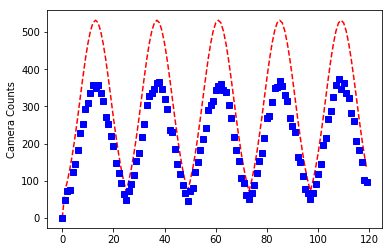

In [3]:
bleedoutrate_true = np.random.normal(0.5, scale=0.1)
print("Bleedout rate is: {}".format(bleedoutrate_true))
truth = cam.runProgramTrue(bleedoutrate_true, 7200, 600) 

Plot the truth data

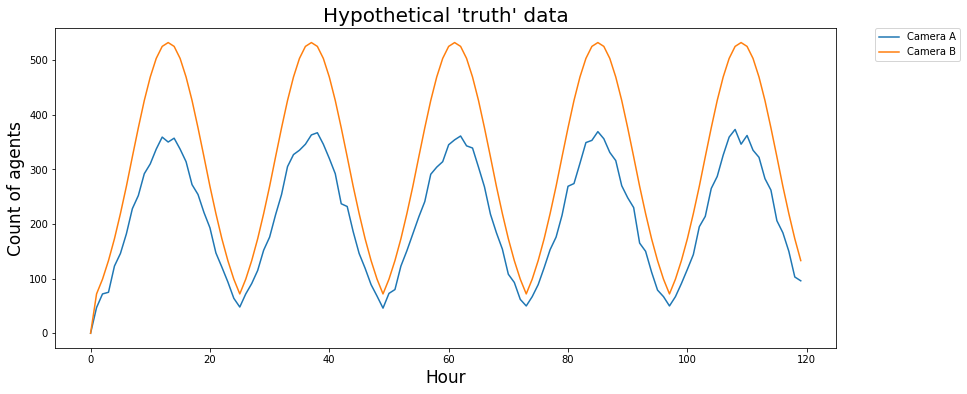

In [38]:
fig = plt.figure(figsize=(14,20))
ax = plt.subplot(3,1,1)
plt.plot(truth[-1][0:120], label="Camera A")
plt.plot(truth[-2][0:120], label="Camera B")

ax.set_xlabel('Hour').set_fontsize(17)
ax.set_ylabel('Count of agents').set_fontsize(17)
ax.set_title("Hypothetical 'truth' data").set_fontsize(20)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Create the ensemble

The 'ensemble' is the group of models that we run simultaneously. For now use an ensemble of size 30 for speed, but ultimately maybe 100 will work better.

Initialise the ensemble drawing the bleed out rate from the prior normal distribution,
mean 0.5 and SD 0.1.

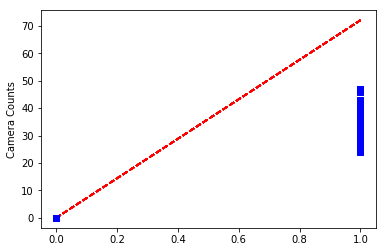

In [5]:
initial = []

for i in range(30):
    bleedoutrate = np.random.normal(0.5, scale=0.1)
    result = cam.runProgram(bleedoutrate, 61, 600)
    initial.append(result)

initial = np.array(initial)

Look at the spread in bleedoutrates across the ensemble

In [6]:
initial[:, -3] 

array([ 0.54365099,  0.50964975,  0.31365073,  0.47226118,  0.4645241 ,
        0.49172585,  0.43729993,  0.49561818,  0.4522782 ,  0.36861352,
        0.58846224,  0.5881318 ,  0.67095731,  0.50500336,  0.45953226,
        0.44546401,  0.34535227,  0.59823674,  0.38989324,  0.38149535,
        0.47943501,  0.64861484,  0.52367163,  0.39762149,  0.42870068,
        0.5625245 ,  0.48394866,  0.42311636,  0.47699693,  0.57450563])

## Forecast Step

In the 'forecast' step, the current (estimated) model state is fed into the model, and the model plays forward until the next observation time (1 hour in this case). This generates a forecast. 

The ensemble forecast mean will give an estimated forecast of the true state, while the covariance of the ensemble forecast states provides a measure of its uncertainty.

Now step each model in the ensemble by running them forward for an hour

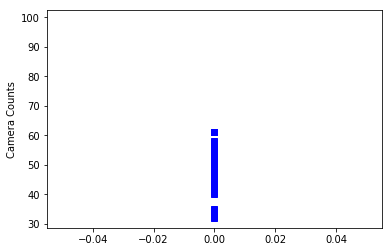

In [7]:
forecasts = []

for i in range(30):
    prediction = cam.runForecast(61, 600, initial[i], 0, 0, 0, steps=60)
    forecasts.append(prediction)
    
forecasts = np.array(forecasts)


### Generate the covariance matrix

We now generate the forecast covariance matrix. This is used to provide a measure of the uncertainty of the ensemble forecasts.

The covariance matrix is an N x N matrix, where:
 - N = M agents locations and route info + bleedoutrate + c_a counts + c_b counts,
 - i.e N = 2M + 3

We find the mean of the forecast ensemble, and find the error from the mean for each value

In [7]:
means = np.mean(forecasts, axis=0)
adjusted = forecasts - means
covariance = np.cov(adjusted.T)

The covariance[-1][-3] measures how the change in bleed out rate affects
the change in the c_b counts

In [8]:
print(covariance[-1][-3])

0.643910517259


## Data Assimilation Step

Upon receiving the actual observation from our 'truth' data, the ensemble forecasts are updated accordingly.  The updated values are called the ensemble analysis. As before, the ensemble analysis mean will give the best estimation of the true state, while the covariance of the ensemble analysis states provides a measure of its uncertainty.

Start by getting the next observation from our truth data (these are counts from the two cameras).

### Prepare virtual and 'real' observations

In [9]:
observation = [truth[-2][2], truth[-1][2]]
print(observation)

[99, 72]


Then we create the virtual observations by assuming additive Gaussian noise (in the real world sensors will never produce 100% accurate estimates of the state of the world, so we assume that our measurements contain some noise).

In [10]:
virtualobs = np.zeros((30,2))

for i in range(30):
    for j in range(2):
        virtualobs[i][j] = observation[j] + np.random.normal(0, 15)

print(virtualobs)

[[ 128.64166175   53.33815007]
 [  89.60374633   59.94350858]
 [  62.7137524    58.14311967]
 [  83.64186359   88.85966938]
 [  97.02128651   47.65071831]
 [ 108.70013178   66.65593861]
 [  72.85288445   63.05025537]
 [  90.1710843    58.89176553]
 [  99.44570723   38.27613349]
 [  94.98357203   87.19775163]
 [ 111.79196761   88.6228125 ]
 [ 115.79085983   94.31314698]
 [  82.22548973   84.68750111]
 [  71.08665707   62.95672344]
 [  70.28291935   87.72221268]
 [ 119.00606729   69.03877981]
 [ 125.61967547   61.87908735]
 [ 101.25925298   74.29418554]
 [  83.03707089   78.56919917]
 [ 128.08467691   56.62603688]
 [ 112.49007669   69.68239722]
 [ 125.54440955   79.25682521]
 [ 109.143246     81.64744921]
 [ 102.7363006    51.06354746]
 [ 119.87494362   51.43996481]
 [ 102.57844789   81.21115632]
 [  86.43131591   74.17594821]
 [ 116.51823429   71.63843295]
 [  85.67013873   28.26393372]
 [  84.42239246   63.13381892]]


### Kalman Gain Matrix

Code the matrix H, the forward model, which is just a transformation matrix changing the state vector into the same form as the observation vector

In [11]:
H = np.zeros((2, 2*600 + 3))

H[-1][-1] = 1
H[0][-2] = 1

Calculate the **Kalman gain matrix**. This is used to balance the impact of the new data on the model states as the real world state should be some combination of an imperfect model and the imperfect real world observations.

R contains the variance of the random errors (i.e 15^2)

In [12]:
P = covariance
R = np.array([[225, 0],[0, 225]])

tbi = np.dot(np.dot(H,P),H.T) + R # (tbi = 'to be inverted')

# We want to solve K tbi = P H.T to find K 
# rewrite to form tbi.T K.T = H P.T'''

LHS = tbi.T
RHS = np.dot(H,P.T)

Ktranspose = np.linalg.lstsq(LHS,RHS)

K = Ktranspose[0].T

### The ensemble analysis

Create the ensemble analysis

In [13]:
ens_analysis = []

for i in range(30):
    tbm = virtualobs[i] - np.dot(H,forecasts[i])
    adjust = forecasts[i] + np.dot(K,tbm)
    ens_analysis.append(adjust)

Average the ensemble analysis and find analysis covariance

In [14]:
ens_means = np.mean(ens_analysis, axis=0)

ens_error = ens_analysis - ens_means

ens_covariance = np.cov(ens_error.T)

That's it! We can now just repeat that process for as many iterations as we want to.

Finish by looking at the ensemble means.

{'boxes': [<matplotlib.lines.Line2D at 0x11b6cc630>],
 'caps': [<matplotlib.lines.Line2D at 0x1194409b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x11b4679e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11b467be0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11b85da90>,
  <matplotlib.lines.Line2D at 0x11b4b6860>]}

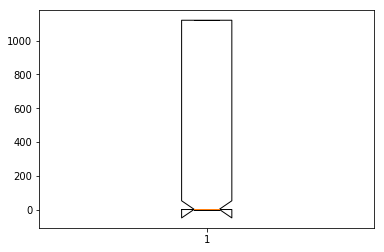

In [15]:
plt.boxplot(ens_means, notch=True)

## Run Full Data Assimilation Cycle

Now repeat the process above, but this time looping for _x_ iterations (i.e. doing data assimilation in earnest). _This will take some time._

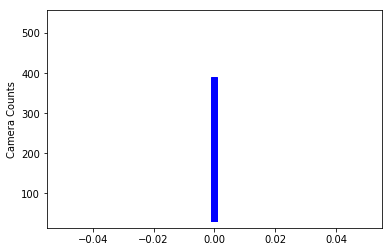

In [16]:
stored_forecast = []
stored_forecast_uncertainty = []
stored_analysis = []
stored_analysis_uncertainty = []
stored_truth = []
stored_parameter = []

forecast_error = []
analysis_error = []
observation_error = []

for n in range(3,120):

    #print(n)

    forecasts = []
    #previously started at time T=241
    for i in range(30):
        prediction = cam.runForecast((((n-1)*60)+1), 600, ens_analysis[i], 0, 0, 0, steps=60)
        forecasts.append(prediction)
    
    forecasts = np.array(forecasts)

    means = np.mean(forecasts, axis=0)
    
    adjusted = forecasts - means

    covariance = np.cov(adjusted.T)

    ''' Begin the data assimilation step '''

    ''' First we extract the next observation from the true data '''

    observation = [truth[-2][n], truth[-1][n]]

    ''' Then we create the virtual observations by assuming additive Gaussian noise '''

    virtualobs = np.zeros((30,2))

    for i in range(30):
        for j in range(2):
            virtualobs[i][j] = observation[j] + np.random.normal(0, 15)

    meansobs = np.mean(virtualobs, axis=0)
    virtualavg = meansobs[-1]

    ''' Code the matrix H, the forward model, which is just a transformation matrix
    changing the state vector into the same form as the observation vector '''

    H = np.zeros((2, 2*600 + 3))

    H[-1][-1] = 1
    H[0][-2] = 1

    ''' Calculate the Kalman gain matrix '''

    P = covariance
    R = np.array([[225, 0],[0, 225]])

    # tbi = 'to be inverted'
    tbi = np.dot(np.dot(H,P),H.T) + R

    ''' We want to solve K tbi = P H.T = RHS to find K 
    rewrite to form tbi.T K.T = H P.T'''

    LHS = tbi.T
    RHS = np.dot(H,P.T)

    Ktranspose = np.linalg.lstsq(LHS,RHS)

    K = Ktranspose[0].T

    ''' Create the ensemble analysis '''

    ens_analysis = []

    for i in range(30):
        tbm = virtualobs[i] - np.dot(H,forecasts[i])
        adjust = forecasts[i] + np.dot(K,tbm)
        ens_analysis.append(adjust)

    ''' Average the ensemble analysis, find analysis covariance '''

    ens_means = np.mean(ens_analysis, axis=0)

    ens_error = ens_analysis - ens_means

    ens_covariance = np.cov(ens_error.T)

    ''' Store the results that we ultimately want to plot '''

    stored_forecast.append(means[-1])
    stored_forecast_uncertainty.append(covariance[-1][-1])
    stored_analysis.append(ens_means[-1])
    stored_analysis_uncertainty.append(ens_covariance[-1][-1])
    stored_truth.append(virtualavg)
    stored_parameter.append(ens_means[-3])
    
    
    forecast_error.append(means[-1] - observation[-1])
    analysis_error.append(ens_means[-1] - observation[-1])
    observation_error.append(virtualavg - observation[-1])

Now plot some results.

The `truth` data that we have been using contains the positions of every agent at every iteration. We just want the camera counts to compare to the simulation.

In [17]:
smallertruth = truth[-1][3:120]

Lets plot the truth data to see what we're trying to simulate. Here are the counts from Camera A and B. (We also saw this earlier)

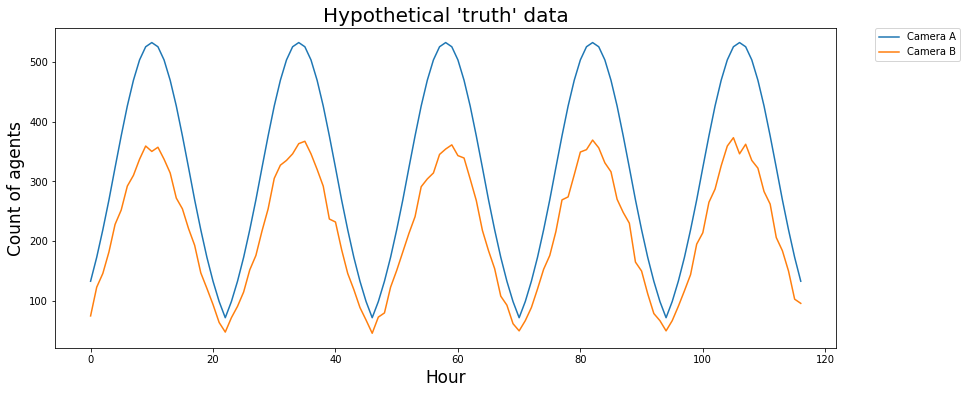

In [37]:
fig = plt.figure(figsize=(14,20))
ax = plt.subplot(3,1,1)
plt.plot(truth[-2][3:120], label="Camera A")
plt.plot(truth[-1][3:120], label="Camera B")


ax.set_xlabel('Hour').set_fontsize(17)
ax.set_ylabel('Count of agents').set_fontsize(17)
ax.set_title("Hypothetical 'truth' data").set_fontsize(20)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Begin with a comparison of the results of the _forecast_ and _analysis_, as well as the _truth_ (our hypothetical real world state which we wouldn't have access to in reality)  and _virtual observations_ (i.e. the truth with some error).

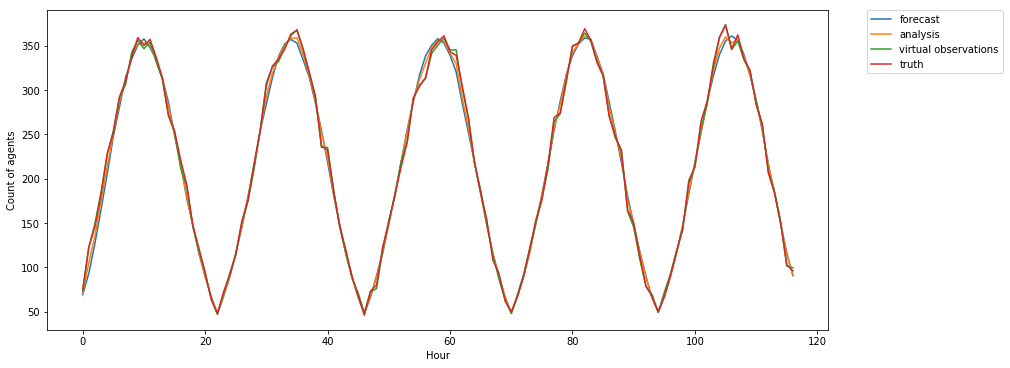

In [39]:
# Define the range of time periods to look over (m -> n)
m = 0
n = 117

fig = plt.figure(figsize=(14,20))
ax = plt.subplot(3,1,1)
plt.plot(stored_forecast[m:n], label="forecast")
plt.plot(stored_analysis[m:n], label="analysis")
plt.plot(stored_truth[m:n], label="virtual observations")
plt.plot(smallertruth[m:n], label="truth")

ax.set_xlabel('Hour')
ax.set_ylabel('Count of agents')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Zoom in on a bit


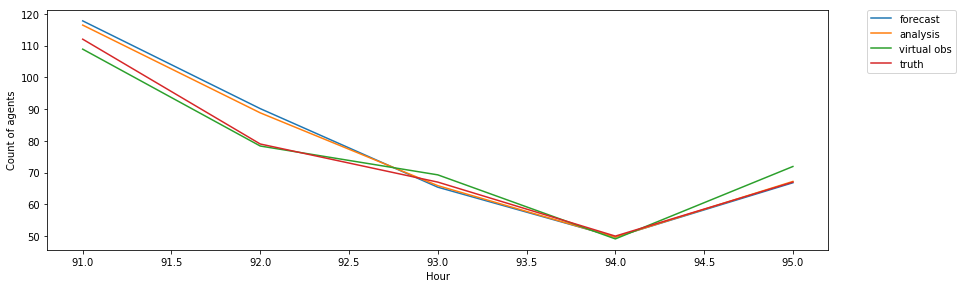

In [45]:
m = 91
n = 96

xaxis = [i for i in range(m,n)]
fig = plt.figure(figsize=(14,15))
ax = plt.subplot(3,1,2)
plt.plot(xaxis, stored_forecast[m:n], label="forecast")
plt.plot(xaxis, stored_analysis[m:n], label="analysis")
plt.plot(xaxis, stored_truth[m:n], label="virtual obs")
plt.plot(xaxis, smallertruth[m:n], label="truth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Hour')
ax.set_ylabel('Count of agents')

Looking at the two figures above, there is little to distinguish the states before and after the data assimilation. The analysis appears to be so close to both the truth and the virtual observations that this level of resolution does not show any clear difference. Even in the zoomed figure the differences are minimal.

Now look at how well the EnKF predicts the unknown parameter ('bleedout rate')

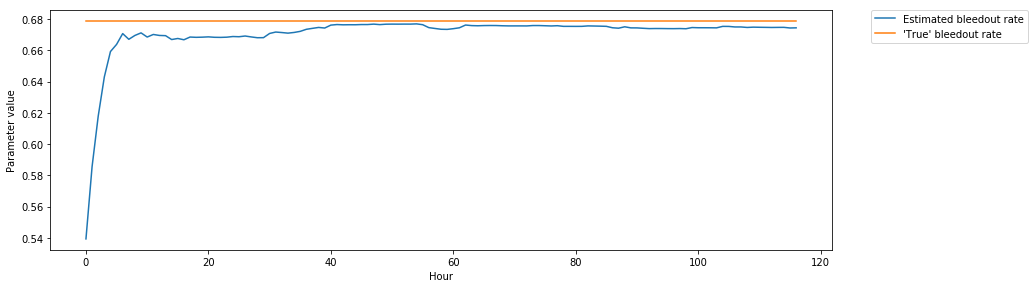

In [50]:
fig = plt.figure(figsize=(14,15))

ax = plt.subplot(3,1,3)
plt.plot(stored_parameter[0:117], label="Estimated bleedout rate")
plt.plot([bleedoutrate_true for i in range(117)], label="'True' bleedout rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('Hour')
ax.set_ylabel('Parameter value')


Happily it finds the 'true' parameter value reasonably quickly.

Finish with a look at the RMSE values.

In [51]:
from numpy import mean, sqrt, square
forecast_RMSE = sqrt(mean(square(forecast_error)))

Forecast RMSE:

In [52]:
forecast_RMSE

9.5612475593297024

Analysis RMSE:

In [53]:
analysis_RMSE = sqrt(mean(square(analysis_error)))
analysis_RMSE

6.625456449985534

In [56]:
observation_RMSE = sqrt(mean(square(observation_error)))
observation_RMSE

2.9722549022353304